# Object Classification - Dog Breed Identification

Hi 🙂, if you are seeing this notebook, you have succesfully started your first project on FloydHub 🚀, hooray!!

![classification](images/classification.png)

In this notebook we will build a classifier to correctly classify the first 10 dog breeds classes(we have reduced the number of class to fit the model in the CPU instance).

Transfer Learning is the wave which brings Deep Learning from Academia to industry, so even if this task seems "trivial", the same model can be applied in all the experiments where you have a small amount of data.

### Resource

The dataset was taken from [Kaggle](https://www.kaggle.com/c/dog-breed-identification).

Who's a good dog? Who likes ear scratches? Well, it seems those fancy deep neural networks don't have all the answers. However, maybe they can answer that ubiquitous question we all ask when meeting a four-legged stranger: what kind of good pup is that?

In this playground competition, you are provided a strictly canine subset of ImageNet in order to practice fine-grained image categorization. How well you can tell your Norfolk Terriers from your Norwich Terriers? With 120 breeds of dogs and a limited number training images per class, you might find the problem more, err, ruff than you anticipated.

![dataset](images/dataset.png)

Inspiration from this [blog post](https://www.depends-on-the-definition.com/transfer-learning-for-dog-breed-identification/) and this [Kaggle Kernel](https://www.kaggle.com/gaborfodor/dog-breed-pretrained-keras-models-lb-0-3).

**Note**

For running a Code Cell, click on the Cell and type `Shift + Enter`.


## Initial Setup

Let's start by importing the packages, Setting the training variables and loading the csv file from which get all the data we need.

In [1]:
# Remove the warning
! pip -q install seaborn h5py==2.8.0rc1

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from tqdm import tqdm
from os import listdir, makedirs
from os.path import join

# For reproducibility
from tensorflow import set_random_seed
from numpy.random import seed
seed(1)
set_random_seed(2)

# Set training given hardware
if tf.test.is_gpu_available(cuda_only=True):
    BATCH_SIZE = 16
    EPOCHS = 3
else:
    BATCH_SIZE = 8
    EPOCHS = 1
    
NUM_CLASSES = 10
SEED = 2018

data_dir = '/floyd/data/dogbreed/'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
print("Total number of samples in the dataset: {}".format(len(listdir(join(data_dir, 'train')))))

print("Top {} labels sorted for descending number of samples".format(NUM_CLASSES))
(labels
 .groupby("breed")
 .count()
 .sort_values("id", ascending=False)
 .head(NUM_CLASSES)
)

Total number of samples in the dataset: 10222
Top 10 labels sorted for descending number of samples


,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


Great, so now we have the list of the top labels sorted by available number of samples in the dataset. Since we have only a few samples for label we will setup a Transfer Learning task from the Xception model (pre-trained on ImageNet) and add data augmentation.

In the next step we will plot some images (with labels) and we will start to split the dataset in two sets, one for training and for validating.

## Train-Val Split

Using TensorFlow backend.


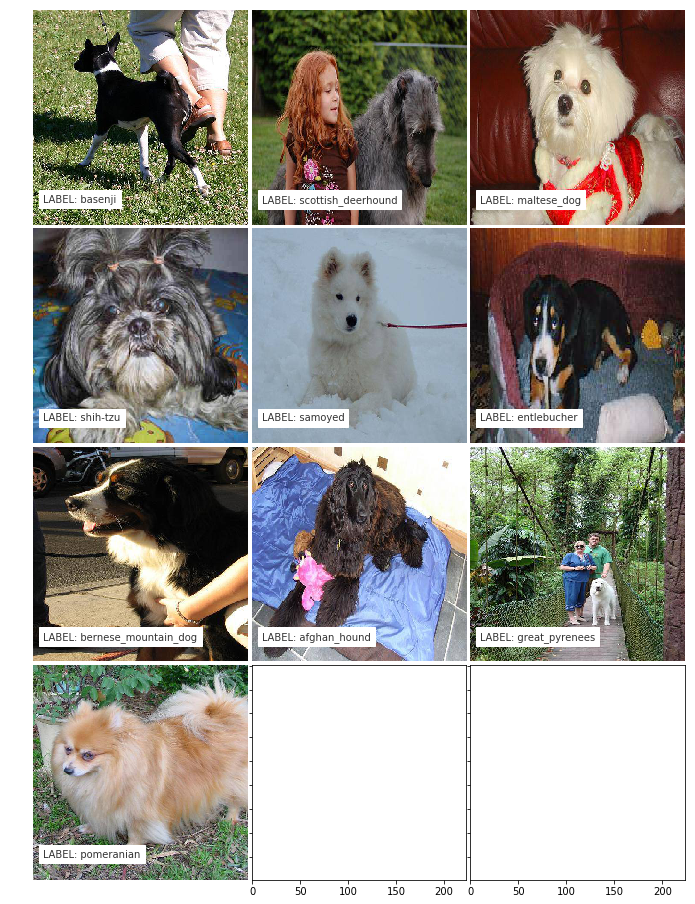

In [4]:
from support import split_train_val

(train_idx, valid_idx, ytr, yv, labels, selected_breed_list) = split_train_val(labels, NUM_CLASSES, seed=SEED)

from keras.preprocessing import image
from support import show_images

show_images(NUM_CLASSES, labels, data_dir)

## Data Loader

The Cell below will preprocess the raw images to be fed into the model. Then we will define the generators which will actually load the data(preprocessed images according to Xception trained on Imagenet) in batches ready to be consumed by the model during the training and evaluation.

In [5]:
# DATA LOADER
from keras.applications import xception
from support import read_img

INPUT_SIZE = 299

x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, data_dir, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Total Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print('Train (images, H, W, C):', Xtr.shape,
      '\nVal (images, H, W, C):', Xv.shape, 
      '\nTrain Labels (images, labels)', ytr.shape,
      '\nVal Labels (images, labels)', yv.shape)

# Data Loader
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator()

1141it [00:08, 127.97it/s]


Total Images shape: (1141, 299, 299, 3) size: 306,019,623
Train (images, H, W, C): (887, 299, 299, 3) 
Val (images, H, W, C): (254, 299, 299, 3) 
Train Labels (images, labels) (887, 10) 
Val Labels (images, labels) (254, 10)


## Model definition

We have built new layers on the top of the Xception model.

In [10]:
### MODEL - BOTTLENECK FEATURES - OPTMIZER

from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input

# create the base pre-trained model
base_model = xception.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have NUM_CLASSES classes
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])

## Train & Evaluate

The Training is defined at the beginning by the type of instance on which runs:

- On a CPU instance it will train for 1 epoch in about 20 minutes with an accuracy of 96% on the Validation Set.

- On a GPU instance it will train for 3 epoch in about 1 minutes with an accuracy of 99% on the Validation Set.

Epoch 1/3
55/55 [==============================] - 26s 478ms/step - loss: 0.5410 - acc: 0.8295 - val_loss: 0.0744 - val_acc: 0.9792
Epoch 2/3
55/55 [==============================] - 24s 435ms/step - loss: 0.3654 - acc: 0.8917 - val_loss: 0.0773 - val_acc: 0.9750
Epoch 3/3
55/55 [==============================] - 24s 433ms/step - loss: 0.3452 - acc: 0.8948 - val_loss: 0.1026 - val_acc: 0.9792
                      precision    recall  f1-score   support

  scottish_deerhound       1.00      1.00      1.00        31
         maltese_dog       1.00      0.90      0.95        20
        afghan_hound       1.00      0.96      0.98        23
         entlebucher       1.00      0.94      0.97        31
bernese_mountain_dog       1.00      1.00      1.00        25
            shih-tzu       0.93      1.00      0.96        26
      great_pyrenees       0.96      1.00      0.98        27
          pomeranian       1.00      1.00      1.00        23
             basenji       0.93      1.00    

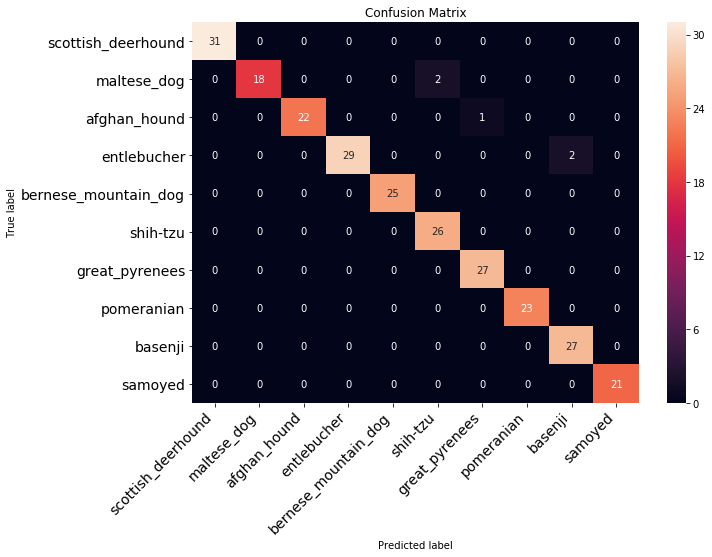

In [11]:
# TRAINING
hist = model.fit_generator(train_datagen.flow(Xtr, ytr, batch_size=BATCH_SIZE),
                           steps_per_epoch=train_idx.sum() // BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=test_datagen.flow(Xv, yv, batch_size=BATCH_SIZE),
                           validation_steps=valid_idx.sum() // BATCH_SIZE)

# Plot confusion matrix
from sklearn.metrics import confusion_matrix
from support import print_confusion_matrix

test_gen = test_datagen.flow(Xv, yv, batch_size=BATCH_SIZE, shuffle=False)
probabilities = model.predict_generator(test_gen)

cnf_matrix = confusion_matrix(np.argmax(probabilities,axis=1), np.argmax(yv, axis=1))
_ = print_confusion_matrix(cnf_matrix, selected_breed_list)

# Print Precision Recall F1-Score Report
from sklearn.metrics import classification_report

report = classification_report(np.argmax(probabilities,axis=1), np.argmax(yv, axis=1), target_names=selected_breed_list)
print(report)

## It's your turn

It's time to test the model on new images to evaluate the performance, have fun :)

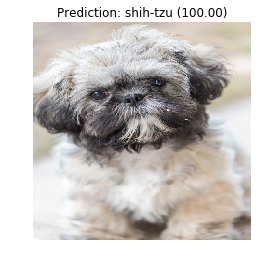

In [13]:
# Testing on url images
from support import prediction_from_url

# Bernese
# URL = 'https://cdn.pixabay.com/photo/2016/02/06/19/18/dog-1183475_960_720.jpg'

# Shih-tzu
URL = 'https://cdn.pixabay.com/photo/2016/10/08/11/21/shih-tzu-puppy-1723492_960_720.jpg'

# Samoyed
# URL = 'https://cdn.pixabay.com/photo/2017/06/14/00/59/samoyed-2400687_960_720.jpg'

prediction_from_url(URL, model, selected_breed_list)

## Save the result

In [14]:
# Saving Model Weight
model.save_weights('models/tl_xception_weights.h5')